# Boston Crime Data Analysis
This project is based on Boston Crime data between 2021-2023 downloaded from [this link](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system)

Please answer the following eight questions and visualize each result. Please label each question clearly.
1. display number of crime by year, order by year
2. display number of crime by year and month in the format of year-month, order by year_month.
3. display average crime by month between 2021 and 2023. Visualize your result.
4. display average, min and max crime by month between 2021 and 2023
5. what time of the day has the highest crime
6. display number of crimes by weekday and the time of the day
7. display top 5 district based on number of crimes
8. for each top 5 districts, display top 5 types of crimes (offense_description) based on number of crimes

In addtion, there are many interesting questions you can explore using this dataset. Please come up at least three questions and develop Pyspark code to answer your questions and visualze the result. Please write a few paragraphs at the end to summarize your findings.

## Import dataset

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from helper_functions import displayByGroup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# create a spark session
spark = SparkSession.builder.appName("Boston Crime Analysis")\
        .config("spark.port.maxRetries", "100")\
        .getOrCreate()

# confiture the log level (defaulty is WWARN)
spark.sparkContext.setLogLevel('ERROR')

# read the csv file, remove year with null value and remove current month (Septmber 2023)
crime = spark.read.csv("/opt/shared/boston_crime", header=True, inferSchema=True).filter(F.isnull(F.col('year'))==False)\
       .filter(F.date_format(F.col('occurred_on_date'), 'yyyy-MM')!='2023-09')

# change all columns to lower case

crime=crime.toDF(*[x.lower() for x in crime.columns])

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/18 06:45:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
crime.printSchema()

In [9]:
displayByGroup(crime, 5)

+---------------+------------+------------------+--------------------------------------------+--------+--------------+
|incident_number|offense_code|offense_code_group|offense_description                         |district|reporting_area|
+---------------+------------+------------------+--------------------------------------------+--------+--------------+
|232006462      |1107        |null              |FRAUD - IMPERSONATION                       |E13     |574           |
|232001473      |1102        |null              |FRAUD - FALSE PRETENSE / SCHEME             |D4      |              |
|232001482      |3820        |null              |M/V ACCIDENT - INVOLVING PEDESTRIAN - INJURY|C6      |186           |
|232001511      |3802        |null              |M/V ACCIDENT - PROPERTY DAMAGE              |C6      |              |
|232001476      |3831        |null              |M/V - LEAVING SCENE - PROPERTY DAMAGE       |B2      |239           |
+---------------+------------+------------------

## Example

## Display top five offense

In [7]:
crime.groupBy('offense_description').count().orderBy(F.desc('count')).limit(5).show()

+--------------------+-----+
| offense_description|count|
+--------------------+-----+
|  INVESTIGATE PERSON|20376|
|         SICK ASSIST|14762|
|M/V - LEAVING SCE...|12145|
|INVESTIGATE PROPERTY| 9375|
| TOWED MOTOR VEHICLE| 8518|
+--------------------+-----+



## Visualize the result

In [9]:
# convert the result to pandas dataframe

pd_df=crime.groupBy('offense_description').count().orderBy(F.desc('count')).limit(5).toPandas()

pd_df.head()

,offense_description,count
0,INVESTIGATE PERSON,20376
1,SICK ASSIST,14762
2,M/V - LEAVING SCENE - PROPERTY DAMAGE,12145
3,INVESTIGATE PROPERTY,9375
4,TOWED MOTOR VEHICLE,8518


<Axes: xlabel='count', ylabel='offense_description'>

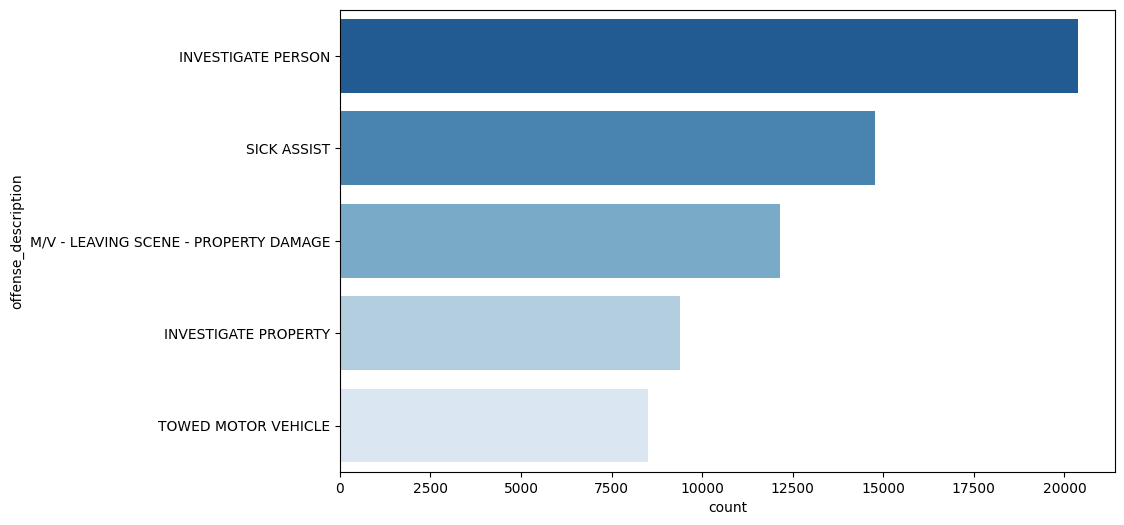

In [19]:
# set the fiture size
plt.figure(figsize=(10,6))

sns.barplot(data=pd_df, y='offense_description',x="count", orient='h', palette='Blues_r')

## Put your solutions in the following section

In [ ]:
## display number of crime by year, order by year

crime.groupBy('year').count().orderBy('year').show()

In [ ]:
## display number of crime by year and month in the format of year-month, order by year_month. Visualize the result

crime1=crime.withColumn('year_month', F.date_format("occurred_on_date", 'yyyy-MM')).select("occurred_on_date", "year_month")

pd_df=crime1.groupBy('year_month').count().orderBy('year_month').toPandas()

pd_df.head(100)

In [ ]:
#!pip install seaborn

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# set the fiture size
plt.figure(figsize=(12,8))

sns.lineplot(data=pd_df, x='year_month', y='count', color="red")

# Sparse labelling
n = 5  # Show every 5th label
labels =pd_df['year_month']
new_labels = ['' if i % n != 0 else labels[i] for i in range(len(labels))]
plt.gca().set_xticklabels(new_labels); # semicolon is used to suppress the output of new_labels

In [ ]:
# display average crime by month between 2021 and 2023. Visualize your result.

pd_df=crime.groupBy('year', 'month').count().groupBy('month').agg(F.avg('count').alias('average_crime')).orderBy('month').toPandas()

pd_df.head(5)

In [ ]:
# set the fiture size
plt.figure(figsize=(10,8))

sns.lineplot(data=pd_df, x='month', y='average_crime', color="blue")

In [ ]:
# display average, min and max crime by month between 2021 and 2023. Visualize your result.

pd_df=(crime.groupBy('year', 'month').count().groupBy('month').
       agg(F.avg('count').alias('average_crime'),
           F.max('count').alias('highest_crime'),
           F.min('count').alias('lowest_crime')          
    ).orderBy('month').toPandas())

pd_df.head(5)

In [ ]:
pd_df1=pd_df.melt(id_vars='month', value_vars=["average_crime", "highest_crime", "lowest_crime"], 
                                   var_name="crime_stats", value_name='numOfCrime')

pd_df1.head()

In [ ]:
# set the fiture size
plt.figure(figsize=(12,8))

sns.lineplot(data=pd_df1, x='month', y="numOfCrime", hue='crime_stats')

In [ ]:
# what time of the day has the highest crime

pd_df=crime.groupBy('hour').count().orderBy('hour').toPandas()

pd_df.head()

In [ ]:
plt.figure(figsize=(12,8))

sns.lineplot(data=pd_df, x='hour', y='count')

In [2]:
# display number of crimes by weekday and the time of the day

pd_df=crime.groupBy('day_of_week', 'hour').count().orderBy('hour').toPandas()
pd_df.head()

,day_of_week,hour,count
0,Wednesday,0,2057
1,Friday,0,2129
2,Saturday,0,2298
3,Thursday,0,2071
4,Sunday,0,2084


<Axes: xlabel='hour', ylabel='count'>

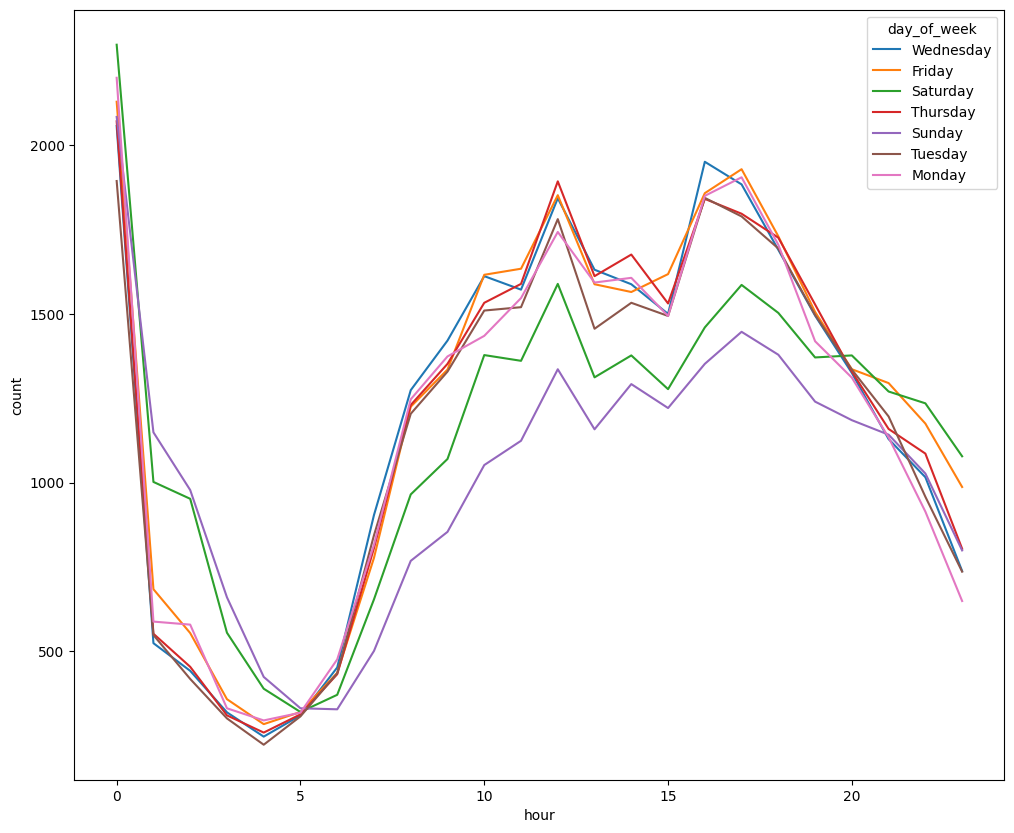

In [5]:
plt.figure(figsize=(12,10))

sns.lineplot(data=pd_df, x="hour", y="count", hue='day_of_week')

In [18]:
# display top 5 district based on number of crimes

top5=crime.groupBy('district').count().orderBy(F.desc('count')).limit(5)
top5.show()

+--------+-----+
|district|count|
+--------+-----+
|      B2|26651|
|      D4|25513|
|     C11|24265|
|      A1|22974|
|      B3|20030|
+--------+-----+



In [23]:
# for each top 5 districts, display top 5 types of crimes (based on offense_description) based on number of crimes

top5_list=top5.toPandas()['district'].tolist()

top5_list

['B2', 'D4', 'C11', 'A1', 'B3']

In [45]:
from pyspark.sql.window import Window

crime1=crime.filter(F.col('district').isin(top5_list)).groupBy('district', 'offense_description').count()

crime2=crime1.withColumn('rank', F.rank().over(Window.partitionBy('district').orderBy(F.desc('count')))).\
      filter(F.col('rank')<=5)

In [47]:
pd_df=crime2.toPandas()
pd_df.head()

,district,offense_description,count,rank
0,A1,SICK ASSIST,2025,1
1,A1,INVESTIGATE PERSON,1845,2
2,A1,ASSAULT - SIMPLE,1465,3
3,A1,LARCENY SHOPLIFTING,1432,4
4,A1,INVESTIGATE PROPERTY,1093,5


<Axes: xlabel='district', ylabel='count'>

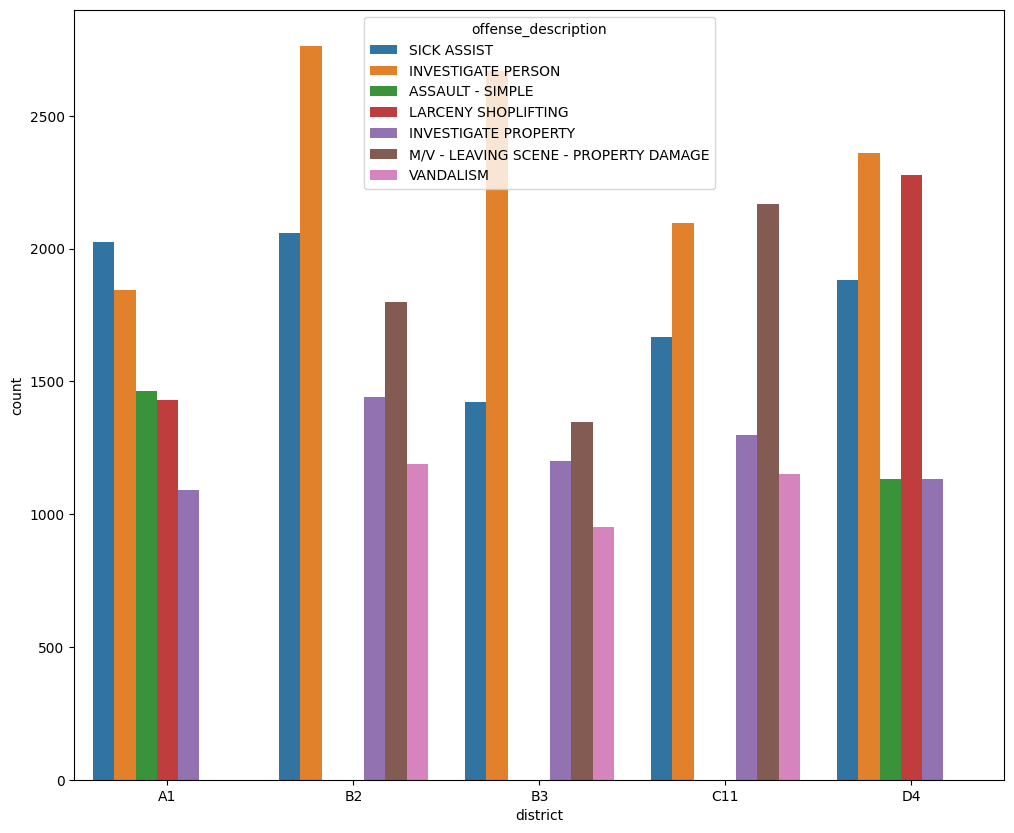

In [49]:
plt.figure(figsize=(12,10))

sns.barplot(data=pd_df, x='district', y='count', hue='offense_description')

In [51]:
# create a map to show crime for a particular day

!pip install folium

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 KB 4.0 MB/s eta 0:00:00


In [84]:
import folium

date='2023-08-30'

cols=['incident_number',
 'offense_description',
 'district',
 'shooting',
 'street',
 'lat',
 'long']

df=crime.filter(F.date_format(F.col('occurred_on_date'), 'yyyy-MM-dd')==date).select(cols).toPandas()
df = df.dropna(subset=['lat', 'long'])

# Create a base map
m = folium.Map(location=[df['lat'].mean(), df['long'].mean()], zoom_start=10)

# Add markers to the map
for _, row in df.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=row[['offense_description', 'district']]
    ).add_to(m)

# Display the map
m
